In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Import useful modules
import numpy as np
import pandas as pd
import seaborn as sns
from utils import plot_ac_filtration, Chain, get_series_lorenz, get_series_rossler, get_embedding, get_features_from_PD,min_volume_linprog_constraints, plot_ac_filtration_2
import gudhi as gd
import cvxpy as cp
import matplotlib.pyplot as plt
from ipywidgets import interactive
from IPython.display import display

# Steniq: Topological Data Analysis and Persistent Homology

Juan Manuel Miramont-Taurel 

- We can consider Topological Data Analysis (TDA) as a **feature extraction** approach.
  
- TDA's goal is to obtain unique fingerprints of data by means of topological features, like the number of **"holes"** in a **point cloud**.

- Persistent Homology captures information about **loops and voids** in a dataset at different **scales.**

## 1. Motivation: the shape of the data

Data with similar summary statistics from [(Matejka, 2017)](https://www.researchgate.net/publication/316652618_Same_Stats_Different_Graphs_Generating_Datasets_with_Varied_Appearance_and_Identical_Statistics_through_Simulated_Annealing)

In [3]:
data = pd.read_csv('../data/datasaurus.csv')
data = data[data['dataset'].isin(['dino','away','star','circle'])]

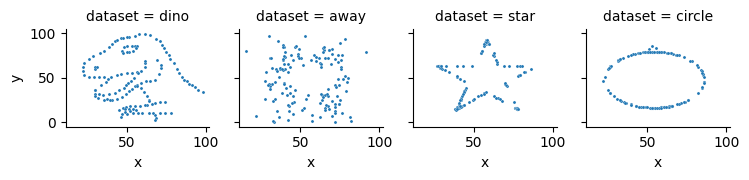

In [4]:
sns.relplot(data=data, x='x', y='y', col='dataset', height=1.9, col_wrap=4, s=5.0)

In [5]:
data.groupby('dataset').agg({'x': ['count','mean', 'std'],'y': ['count','mean', 'std']})

x                           y                      
        count       mean        std count       mean        std
dataset                                                        
away      142  54.266100  16.769825   142  47.834721  26.939743
circle    142  54.267320  16.760013   142  47.837717  26.930036
dino      142  54.263273  16.765142   142  47.832253  26.935403
star      142  54.267341  16.768959   142  47.839545  26.930275

In [6]:
data.groupby("dataset").corr()

x         y
dataset                      
away    x  1.000000 -0.064128
        y -0.064128  1.000000
circle  x  1.000000 -0.068343
        y -0.068343  1.000000
dino    x  1.000000 -0.064472
        y -0.064472  1.000000
star    x  1.000000 -0.062961
        y -0.062961  1.000000

- **Can we get a more precise description of the *shape* of the data?**



## 2. Simplicial Complexes
- Obtain a computationally tractable representations of the structure of the data. 
- Preserve the topological invariants we are interested in.

- **Simplex**: A $p$-simplex $\sigma_{p}$ is the convex hull of $p+1$ affinely independent points:
  - **Examples:** $0$-simplex is a point, $1$-simplex is an edge, $2$-simplex a triangle, $3$-simplex a tetrahedron, and so on.
- A **Simplicial Complex** $K$ is a finite set of simplices such that 
    1. If $\sigma\in K$, and $\tau$ is a face of $\sigma$, then $\tau\in K$.
    2. If $\sigma,\tau \in K$, then $\sigma\cap\tau$ is either empty or a common face.
- There are different types of simplicial complexes:
  - Cech Complex
  - Vietoris-Rips Complex
  - **Alpha Complex**
    - $\operatorname{Alpha}(r) = \{\sigma \subseteq S: \bigcap\limits_{u\in\sigma} (B(u,r)\cap V_{u}) \neq \emptyset \}$.
    - $V_u$ is the Voronoi cell associated with $u$.

- Henceforth, $K(r) = \operatorname{Alpha}(r)$. 

AttributeError: 'Polygon' object has no attribute 'intersection'

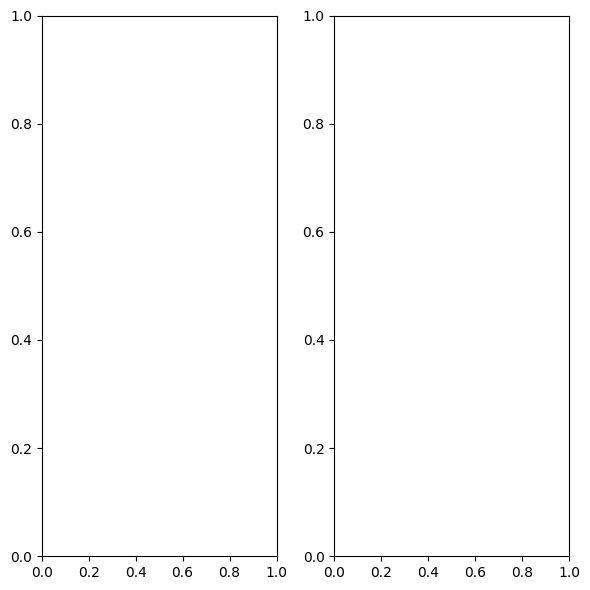

In [7]:
# Example of an Alpha Complex for a given r
r = 4.25
fig, axs = plt.subplots(1,2, figsize=(6,6),layout='tight')

points_star = data[data['dataset']=='star'].iloc[:,1:3].to_numpy()
ac_star = gd.AlphaComplex(points_star)
st_star = ac_star.create_simplex_tree()
filt_star = list(st_star.get_filtration())

plot_ac_filtration(points_star.copy(), filt_star, r**2, ax=axs[0], voronoi=False)
axs[0].axis('square')
axs[0].set_xlim([0,100])
axs[0].set_ylim([0,100])
axs[0].set_title(r'$K(r)$ - $r={:.2f}$'.format(r))   

points_dino = data[data['dataset']=='dino'].iloc[:,1:3].to_numpy()
ac_dino = gd.AlphaComplex(points_dino)
st_dino = ac_dino.create_simplex_tree()
filt_dino = list(st_dino.get_filtration())

plot_ac_filtration(points_dino.copy(), filt_dino, r**2, ax=axs[1], voronoi=False)
axs[1].axis('square')
axs[1].set_xlim([0,100])
axs[1].set_ylim([0,100])
axs[1].set_title(r'$K(r)$ - $r={:.2f}$'.format(r))   

### Filtrations
As $r$ grows, for $r=0,\dots,r_{\max}$, we get:
$$
\mathbb{K}: \emptyset = K(0) \dots \subset K(r) \subset \dots  \subset K(r_{\max}) 
$$

The nested sequence of sets for $K(r)$ is called a **filtration**.

In [ ]:
def renderer(r):
    fig, axs = plt.subplots(1,1, figsize=(6,6))
    axs.axis('square')
    axs.set_xlim([0,100])
    axs.set_ylim([0,100])    
    plot_ac_filtration(points_dino.copy(), filt_dino, r**2, voronoi=False, ax=axs)
    axs.set_title(r'$K(r)$ - $r={:.2f}$'.format(r))    
    # plt.show()

v = interactive(renderer, r=(1, 20, 0.25))
display(v)

interactive(children=(FloatSlider(value=10.0, description='r', max=20.0, min=1.0, step=0.25), Output()), _dom_…

## 3. $p$-chains and homology
### $p$-chains:
A $p$-chain is a formal sum of $p$-simplices: $\sum^{n_{p}}_{i=1}\lambda_{i} \sigma_{i}$, $\sigma_i\in K$, $\lambda_{i}\in\mathbb{Z}_{2}$


(-0.25, 5.25, -0.05, 1.05)

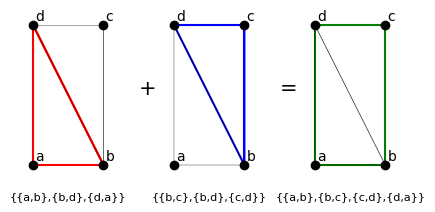

In [ ]:
# Plots
# Individual 1-simplices
# Chain summing the individual 1-simplices
points_chains = np.array([[0,0],[0,1],[1,0],[1,1]])
points_name = ['a','d','b','c']
chain1 = Chain(np.array(([0,1],[1,2],[2,0])))
chain2 = Chain(np.array(([1,2],[2,3],[3,1])))

fig, ax = plt.subplots(1,1,figsize=(5,2))

ax.plot(points_chains[chain1.comps,0],points_chains[chain1.comps,1],'r')
ax.plot(points_chains[chain2.comps,0],points_chains[chain2.comps,1],'k',linewidth=0.5, alpha=0.5)
ax.plot(points_chains[:,0],points_chains[:,1],'ko')
[ax.text(p[0]+0.03,p[1]+0.03,name) for p,name in zip(points_chains,points_name)]

ax.text(1.5,0.5,'+',fontsize=15)

ax.plot(points_chains[chain2.comps,0]+2,points_chains[chain2.comps,1],'b')
ax.plot(points_chains[chain1.comps,0]+2,points_chains[chain1.comps,1],'k',linewidth=0.5, alpha=0.5)
ax.plot(points_chains[:,0]+2,points_chains[:,1],'ko')
[ax.text(p[0]+2+0.03,p[1]+0.03,name) for p,name in zip(points_chains,points_name)]

ax.text(3.5,0.5,'=',fontsize=15)

chain3 = chain1+chain2
for c in chain3.comps:
    ax.plot(points_chains[c,1]+4,points_chains[c,0],'g')
ax.plot(points_chains[:,0]+4,points_chains[:,1],'ko')
[ax.text(p[0]+4+0.03,p[1]+0.03,name) for p,name in zip(points_chains,points_name)]

ax.plot(points_chains[chain1.comps,0]+4,points_chains[chain1.comps,1],'k',linewidth=0.5, alpha=0.5)
# ax.plot(points_chains[chain2.comps,0]+4,points_chains[chain2.comps,1],'k',linewidth=0.5, alpha=0.5)

ax.text(0.5,-0.25,'{{a,b},{b,d},{d,a}}',fontsize=8, horizontalalignment='center')
ax.text(2.5,-0.25,'{{b,c},{b,d},{c,d}}',fontsize=8, horizontalalignment='center')
ax.text(4.5,-0.25,'{{a,b},{b,c},{c,d},{d,a}}',fontsize=8, horizontalalignment='center')
ax.axis('Off')


### Three important groups:
1. The **p-chain group** $C_{p}(r)$ includes **all $p$-chains in $K(r)$**, given $r$.

2. The **p-cycles group** $Z_{p}(r)$ includes **all closed cycles in $K(r)$**.

3. The **boundary group** $B_{p}(r)$ includes **all boundaries in $K(r)$**.
    - **Example**: For a 2-simplex $\sigma=\{a,b,c\}$ we get $\partial_{2} \sigma = \{ \{a,b\}, \{b,c\},\{c,a\} \}$. 
    - $\partial_p: C_{p}(r) \to C_{p-1}(r)$ is called *the boundary map*.


- $B_{p}(r) \subset Z_{p}(r) \subset C_{p}(r)$

More formally:
- $B_{p}(r) = \operatorname{Im}\partial_{p+1}$.
- $Z_{p}(r) = \operatorname{ker}\partial_{p}$.

Where $\partial_p: C_{p}(r) \to C_{p-1}(r)$ is called *the boundary map*. 
- $\partial_p$ returns the boundaries of the $p$-simplices.
  - **Example**: For a 2-simplex $\sigma=\{a,b,c\}$ we get $\partial_{p} \sigma = \{ \{a,b\}, \{b,c\},\{c,a\} \}$


### Homology
Homology can be considered as a tool to **count the number of holes** in a simplicial complex $K(r)$, for a fix $r$.

- In a 2D $K(r)$, holes are 1-dimensional loops, or **closed** cycles in $K(r)$.
- $Z_{p}(r)$ includes all the boundaries in $B_{p}(r)$ , but we are **not** interested in the latter, since these are *trivial* holes.

The $p$-homology group is then defined as a **quotient space** given by:
$$
H_{p}(r) = \frac{Z_{p}(r)}{B_{p}(r)}
$$
- Each element in $H_{p}(r)$ **is an equivalent class** of cycles.
- Two cycles describe the same hole if one can go from one cycle to the other by adding elements in $B_{p}(r)$.
- The dimension of $H_{p}(r)$ is called **Betti number** $b_{p}$, and counts the number of $p$-dimensional holes in $K$.
    - Example: the dimension of $H_{1}(r)$ count the number of loops. 


But... how can we **chose $r$** so that $K(r)$ reflects the *actual* structure of the data?

## 4. Persistent homology and the persistence diagram
Informally: Persistent homology measures how homology elements **(holes, voids, etc)** *persist* (**remain non-trivial**) at different scales of the data.

- As $r$ is changed, $H_p(r)$ gains some classes and loose others: holes appear (**born**) and later are filled with 2-simpleces (**die**) as $r$ grows.
- A **persistence diagram** is a way of keep track of these changes, while indicating long-lasting components that characterize the data.

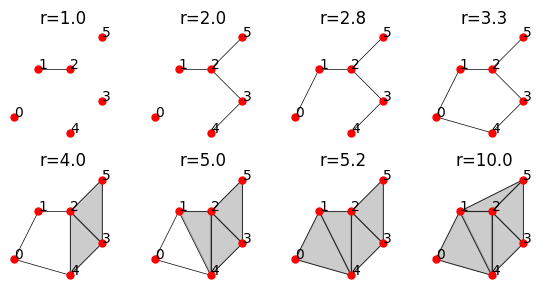

In [ ]:
# Example
points_example = np.array([[-0.5,0],[1,3],[3,3],[5,1],[3,-1],[5,5]],dtype=float)

ac_sig = gd.AlphaComplex(points_example)
st = gd.AlphaComplex(points_example).create_simplex_tree()
persistence = st.persistence()

filtration = list(st.get_filtration())
radii = np.unique([fff[1] for fff in filtration])

fig, axs = plt.subplots(2,4, figsize=(6,3), layout='tight')

for i,ax in enumerate(axs.flatten()):
    plot_ac_filtration_2(st, points_example, radii[i+1], ax=ax)
    ax.axis('square')
    ax.set_title('r={:.1f}'.format((radii[i+1])))

/home/juan/Nextcloud/Lille/steniq/.venv/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


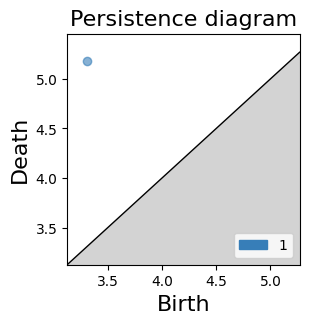

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(3,3))

# plot persistence diagram
gd.plot_persistence_diagram([p for p in persistence if p[0]==1],axes=axes)

plt.show()

More formally:

- Given a filtration: $K_{1}, \subset K_{2} \dots \subset K_{r_{\max}} = K$
- $H_p(\mathbb{K}): H_p(1) \to \dots \to H_p(r) \to \dots \to H_p(r_{\max})$
- The mappings $H_p(s) \to H_p(t),\; s<t$, are induced by the inclusion mapping between $K(s)$ and $K(t)$.
- Persistent homology can be decomposed in mappings of the form:
  - $0 \to \mathbb{F}$ (Component birth)
  - $\mathbb{F} \to \mathbb{F}$ (Component persists)
  - $\mathbb{F} \to 0$ (Component death)
- This is the information represented in the **persistence diagram**:


In [ ]:
from utils import compute_boundary_operators, reduction
B1,B2 = compute_boundary_operators(filtration)
B2red = reduction(B2.copy())[0]
B2_df = pd.DataFrame()
# for i,col in enumerate(('(2,4,3)','(2,4,3)','(1,4,2)','(0,1,4)','(1,2,5)')):
for i,col in enumerate([s[0] for s in filtration if len(s[0])==3]):
    B2_df[str(col)]= B2red[:,i] 

B2_df.index = [str(s[0]) for s in filtration if len(s[0])==2]
print('Reduced Annotated Boundary Matrix')
B2_df

Reduced Annotated Boundary Matrix


,"[2, 3, 4]","[2, 3, 5]","[1, 2, 4]","[0, 1, 4]","[1, 2, 5]"
"[1, 2]",0,0,1,1,-1
"[2, 3]",1,-1,0,1,0
"[3, 4]",1,0,0,1,0
"[2, 5]",0,1,0,0,-1
"[0, 1]",0,0,0,1,0
"[0, 4]",0,0,0,1,0
"[2, 4]",1,0,-1,0,0
"[3, 5]",0,1,0,0,0
"[1, 4]",0,0,1,0,0
"[1, 5]",0,0,0,0,1


- **Geometry Understanding in Higher Dimensions [(`guhdi`)](https://gudhi.inria.fr/)** is a open source C++ library, with a Python interface for TDA. 
The library offers state-of-the-art data structures and algorithms to construct simplicial complexes and compute persistent homology.

## 6. Applications


### 6.1. Extracting features from persistence diagrams 

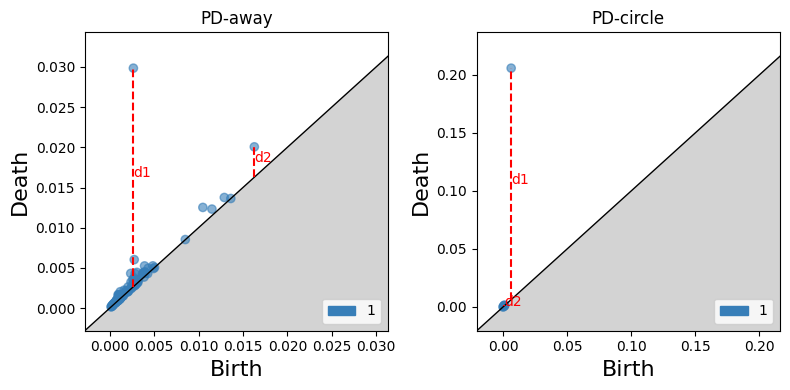

In [ ]:
fig, ax = plt.subplots(1,2,layout='tight', figsize=(8,4))
aux_dic = {'dataset':[],'d1':[],'d2':[]}
for j,dataset in enumerate(np.unique(data['dataset'])[0:2]):
    df = data[data['dataset']==dataset]
    points_d = df.iloc[:,1::].to_numpy()
    pair_lives, persistence = get_features_from_PD(points_d, sort=False)
    gd.plot_persistence_diagram([p for p in persistence if p[0]==1], axes=ax[j])
    max_ind = np.argsort(pair_lives)[::-1]
    for i in range(2):
        arrow_coord=persistence[max_ind[i]][1]
        ax[j].plot((arrow_coord[0],arrow_coord[0]),(arrow_coord[0],arrow_coord[1]),'--r')
        ax[j].text(arrow_coord[0],arrow_coord[0]+(arrow_coord[1]-arrow_coord[0])/2,'d{}'.format(i+1),color='r')
    ax[j].set_title('PD-'+dataset) 


In [ ]:
# Get distances from the persistence diagram for each dataset:
aux_dic = {'dataset':[],'d1':[],'d2':[]}
for dataset in np.unique(data['dataset']):
    df = data[data['dataset']==dataset]
    points_d = df.iloc[:,1::].to_numpy()
    for j in range(30):
        noisy_points = points_d+0.5*np.random.randn(points_d.shape[0],points_d.shape[1])
        pairs_lives,_ = get_features_from_PD(noisy_points)  
        aux_dic['dataset'].append(dataset)
        aux_dic['d1'].append(pairs_lives[0])
        aux_dic['d2'].append(pairs_lives[1])

df_features = pd.DataFrame(aux_dic)
df_features = df_features.reset_index(0)

import plotly.express as px

px.scatter(df_features,x='d1',y='d2',color='dataset')

Similar applications:
- COVID-19 differential diagnosis from CT images [(Iqbal, 2021)](https://arxiv.org/abs/2102.10593)

### 6.2. Classify signals with different dynamics
- Time series can be represented by a higher dimension embedding (evolution of dynamics in phase space) that reveals contrasting dynamics when they come from different systems.

In [ ]:
Y = get_series_lorenz(5000)
lorenz_emb = get_embedding(3,3,Y[:,0])
Y = get_series_rossler(10000)
rossler_emb = get_embedding(3,65,Y[:,0])

px.line_3d(lorenz_emb,x='x1',y='x2',z='x3',title='Lorenz')

In [ ]:
px.line_3d(rossler_emb,x='x1',y='x2',z='x3',title='Rossler')

Text(0.5, 1.0, 'PD - Rossler')

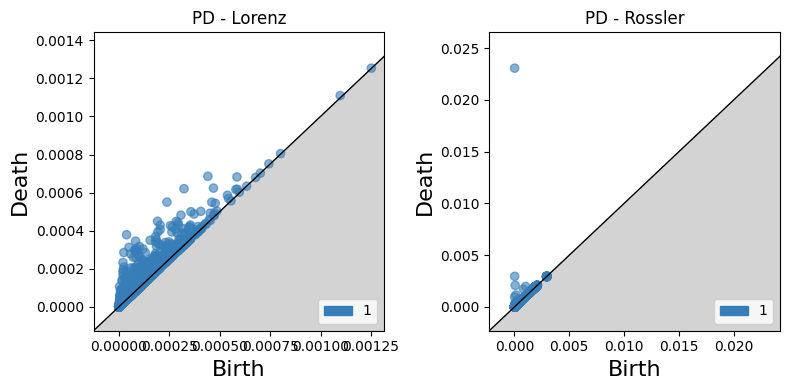

In [ ]:
points_lor = lorenz_emb.iloc[:,0::].to_numpy()
_, persistence_lor = get_features_from_PD(points_lor)

points_ros = rossler_emb.iloc[:,0::].to_numpy()
_, persistence_ros = get_features_from_PD(points_ros)

fig, ax = plt.subplots(1,2,figsize = (8,4),layout='tight')
gd.plot_persistence_diagram([p for p in persistence_lor if p[0]==1], axes=ax[0])
gd.plot_persistence_diagram([p for p in persistence_ros if p[0]==1], axes=ax[1])
ax[0].set_title('PD - Lorenz')
ax[1].set_title('PD - Rossler')

In [ ]:
# Getting time series:
nseries=15
series = np.vstack((get_series_lorenz(2000,n=nseries),get_series_rossler(2000,n=nseries)))
labels = ['lorenz' if i<nseries else 'rossler' for i in range(2*nseries)] 

In [ ]:
# Pipeline 
# Heads-up: This can crash from time to time, because I'm using Euler method to get the time series and it might not converge. Try to re-run.

aux_dic = {'system':[],'d1':[],'d2':[]}
for s,label in zip(series,labels):
# 1- Compute the embedding
    if label=='lorenz': 
        emb = get_embedding(3,5,s)
    else:
        emb = get_embedding(3,65,s)
    points_series = emb.iloc[:,0::].to_numpy()
    pairs_lives,_ = get_features_from_PD(points_series)               
# 2- Compute the persistent homology
    aux_dic['system'].append(label)
    aux_dic['d1'].append(pairs_lives[0])
    aux_dic['d2'].append(pairs_lives[1])    

In [ ]:
df_features = pd.DataFrame(aux_dic)
df_features = df_features.reset_index(0)
px.scatter(df_features,x='d1',y='d2',color='system')

- Similar principles have been used to classify time series in different contexts:
  - Nonlinear dynamics [(Maletic, 2015)](https://arxiv.org/pdf/1510.06933.pdf)
  - Biomedical signals (attrial fibrillation) [(Safarbali, 2019)](https://doi.org/10.1016/j.bspc.2019.101563)
  - Accelerometers signals (movement classification) [(Venkataraman, 2016)](https://ieeexplore.ieee.org/document/7533141)

### 6.3. Recovering components
<!-- - The "Fundamental conundrum of TDA" [(Bendich, 2015)](https://arxiv.org/abs/1512.01700):  -->
- Given a birth-death pair in the PD, locate a *representer* of the homology component.
- The solution is not unique. We would like the *minimal* cycle that belong a given homology class.

In [ ]:
points2 = data[data['dataset']=='away'].iloc[:,1:3].to_numpy()

# Compute Alpha Complex filtration
ac = gd.AlphaComplex(points2)
st = ac.create_simplex_tree()
filtration = list(st.get_filtration())
pers = st.persistence()

# Get pairs from the persistence
pairs = np.array([p[1] for p in pers if p[0]==1])
idx = np.argsort(pairs[:,1]-pairs[:,0])[::-1]

# Most significant component
pair = pairs[idx[0]]

# Get simplex from the filtration at r = death
simplex1 = np.array([simplex[0] for simplex in filtration if len(simplex[0])==2 and simplex[1]<=pair[1]])

NameError: name 'data' is not defined

In [ ]:
# Solve a linear program to compute a minimum-volume cycle

# Get constraints matrix and initial cycle
A, B2, nvars, b, c1, simp2 = min_volume_linprog_constraints(filtration, pair)

# Define the linear program constraints and objective
x = cp.Variable(nvars, integer=False)
constraints = [
            A @ x == b, 
            x>=0,
            x<=1,
            ]
objective = cp.Minimize(cp.norm1(cp.multiply(c1,x)))


In [ ]:
# Solve
problem = cp.Problem(objective, constraints)
problem.solve()

xsol = x.value
xsol[np.abs(xsol)>0.05] = True
xsol[np.abs(xsol)<=0.05] = False
xsol = xsol.astype(bool)

xsol_aux = np.abs(np.matmul(B2,xsol.astype(B2.dtype))).astype(bool)
sol_comps = simplex1[:len(xsol_aux)][xsol_aux]

/home/juan/Nextcloud/Lille/steniq/.venv/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning:


    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    



(-36.70421817690809, 261.6186092244694, -36.70421817690809, 261.6186092244694)

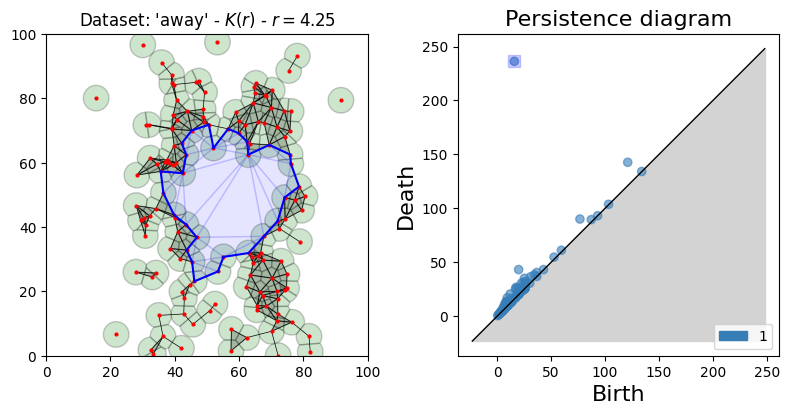

In [ ]:
# Plot again the original simplicial complex
fig, axs = plt.subplots(1,2, figsize=(8,5), layout='tight')
plot_ac_filtration(points2.copy(), filtration, pair[0], ax=axs[0],voronoi=False)
axs[0].axis('square')
axs[0].set_xlim([0,100])
axs[0].set_ylim([0,100])
axs[0].set_title(r"Dataset: 'away' - $K(r)$ - $r={:.2f}$".format(r))

# Plot the representer:
for tau in sol_comps:
    axs[0].plot(points2[tau,0],points2[tau,1],color='b')

for indices in simp2[xsol]:
    axs[0].fill(points2[indices,0], points2[indices,1], color="blue", alpha=0.1)

gd.plot_persistence_diagram([p for p in pers if p[0]==1], axes=axs[1])
axs[1].plot(pair[0],pair[1],'bs', ms=8, alpha=0.2)
axs[1].axis('square')

Computing homology representers can be useful:

- Study the structure of amorphous solids [(Hiraoka, 2016; ](https://www.pnas.org/doi/10.1073/pnas.1520877113) [Obayashi,2021)](https://arxiv.org/abs/1712.05103)
- Typical cycles in chromatine and protein folding [(Emmet and Schweinhart, 2015)](https://arxiv.org/abs/1511.01426)

## Conclusions
- Topological Data Analysis provides tools that characterize the *shape* of data.
  
- We can exploit the vector space structure of homology to count *voids* in higher dimensions.

- Persistence homology describe these voids at different *scales*.

- It can be applied to data expressed as point clouds or images.

- The features extracted can be feed to machine learning/ deep learning algorithms.